# Working with RDF data in python

Raphael Leung

Open data serves a public good. It boosts transparency, accountability, and creates economic value (£16 billion a year, [according to Deloitte](https://www2.deloitte.com/content/dam/Deloitte/uk/Documents/deloitte-analytics/open-growth.pdf)). Folks at the [ODI](https://theodi.org/knowledge-opinion/) and [Open Data Camp](http://odcamp.org.uk/) have written more about that.

I've been working at the UK Parliamentary Digital Service on open data. Under the hood, we turn open parliamentary data from sources (mostly relational stores) into a graph with an ETL process, which is then exposed via APIs and consumed by, among others, beta.parliament.uk. ([technical details](https://medium.com/@langsamu/api-parliament-uk-7b87597019a4)).

### What's RDF?

But what graph and why? There are [many types and models](https://en.wikipedia.org/wiki/Network_science) of graphs. Commonly, the term [property graph](https://github.com/tinkerpop/gremlin/wiki/Defining-a-Property-Graph) has come to denote an attributed, multi-relational graph, i.e a graph where the edges are labeled and both vertices and edges can have any number of key/value properties associated with them. This (labeled) property graph model is commonly seen in graph databases like neo4j and some network sciences analysis. While related and increasingly commercially commonplace, here, we discuss the RDF model instead.

Unlike other graph models, Resource Description Framework ([RDF](https://en.wikipedia.org/wiki/Resource_Description_Framework)) is a W3C specification. Its standard query language is called SPARQL Protocol and RDF Query Language (yes, the "S" in SPARQL stands for SPARQL). Along with the Web Ontology Language (OWL), these standards commonly feature in discussions about [the semantic web](https://www-sop.inria.fr/acacia/cours/essi2006/Scientific%20American_%20Feature%20Article_%20The%20Semantic%20Web_%20May%202001.pdf), [linked open data](https://5stardata.info/en/), and knowledge graphs. 

### The semantic web... is it alive or dead?! Should I care?

RDF has been championed by, among others, [ODI founders](https://theodi.org/about-the-odi/odi-team/) Tim Berners-Lee and Nigel Shadbolt. They have knighthoods and Sir Tim is the inventor of the World Wide Web! They must know what they're saying.

But, over the years, there're others who disagree ([Exhibit A](http://blog.diffbot.com/rip-the-semantic-web/),  [Exhibit B](http://manu.sporny.org/2014/json-ld-origins-2/)). If you have appetite for this sort of thing, [just put "is the semantic web dead?" into your search engine of choice](http://lmgtfy.com/?q=is+the+semantic+web+dead%3F) and you'll get many counter-opinions. 

Without stoking any fires, here's a quick, hopefully-neutral summary:

* While RDF (adopted as W3C recommendation in 1999; RDF 1.0 published in 2004) has not taken off as other W3C standards have, it is still used in many domains (see [linked data cloud](http://lod-cloud.net/)).
* It's been especially used in government linked data infrastructures across the world, including legislation.gov.uk and data.gov.uk (see [webinars](https://dl.dropboxusercontent.com/s/vgmhmwd8e01bks8/external.xhtml?dl=0), [re-usable ontologies](https://eur-lex.europa.eu/eli-register/about.html), [vocabularies](http://lov.okfn.org/dataset/lov/)).
* There are troves of web data in RDF already, e.g. [wikidata](https://query.wikidata.org/), that would be even more valuable if linked. Indeed, some say linked open data enables large-scale data integration between domains so you can ask more questions from a contextually-relevant graph. 
* As publishers of open data, if others (humans and machines) can more easily discover and/or re-use your data, you potentially have greater value and impact for your investment.
* Adoption of RDF may be slow due to its relative complexity in implementation. 
  * Some inference rulesets make an RDF store grow exponentially in statements. That said, open-source and commercial RDF stores have been increasingly bolstered, optimized, and integrated with current technologies and infrastructures. (We've come a long way since the [Berlin SPARQL Benchmark](https://pdfs.semanticscholar.org/0efc/d1d38ad020da7c01613b7818eb123cb34121.pdf) found relational stores to be much more performant than RDF stores in 2008, the same year SPARQL 1.0 became a W3C recommendation.) In late 2017, the world's biggest cloud provider launced a [product](https://aws.amazon.com/neptune/) that supports RDF and its standard query language SPARQL. Neptune doesn't currently support inference.
  * Some point out that open data should be as easy to access and use as possible, regardless of technical skill.
  * Accessing RDF data from a SPARQL endpoint requires a query language that many users do not know.  The open data publisher can, however, package SPARQL queries/ serialize data into other more common formats/ expose via protocols like OData/ use creative visualizations and interfaces/ otherwise make the data more accessible. This, however, requires investment of resources and time.
* Some intended benefits of RDF and OWL are not necessarily tied to the formats themselves, e.g. a lot of the benefits can be achieved with stable unique identifiers and good data governance. 
* Semantic web standards play well with a suite of tools and concepts in taxonomy and knowledge management (particularly well-adopted in LIS).

### What's support for RDF data in python like?

Our ETL pipeline for data orchestration is in C# and uses an open-source library called [dotNetRDF](http://www.dotnetrdf.org/). 

But, in the vein of making it easier to access and understand, can we easily work with RDF data in python?

To find out, I first try to load some data from a pandas dataframe into an RDF store (Part 1). 

Then I try to query an RDF store and try to turn the results into pandas dataframes (Part 2). 

### Part 1: Pandas dataframe &rightarrow; RDF

In [1]:
import rdfpandas.graph
import pandas as pd
import rdflib
import requests

### Create relational version of some sample RDF data

In [2]:
df = pd.DataFrame(data = {
        'http://www.w3.org/1999/02/22-rdf-syntax-ns#type': ['https://id.parliament.uk/schema/House', 'https://id.parliament.uk/schema/House'], 
        'https://id.parliament.uk/schema/houseName': ['House of Commons', 'House of Lords'], 
        'https://id.parliament.uk/schema/househasHouseSeat': ['https://id.parliament.uk/Z7YQPdng', ""], 
        }, 
        index=['https://id.parliament.uk/1AFu55Hs', 'https://id.parliament.uk/WkUWUBMx'])
df

,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,https://id.parliament.uk/schema/houseName,https://id.parliament.uk/schema/househasHouseSeat
https://id.parliament.uk/1AFu55Hs,https://id.parliament.uk/schema/House,House of Commons,https://id.parliament.uk/Z7YQPdng
https://id.parliament.uk/WkUWUBMx,https://id.parliament.uk/schema/House,House of Lords,


### Convert dataframe to RDF graph

Turtle is one RDF serialization format. Others include N-triples, N-Quads, RDF/XML, JSON-LD, TriG, TriX [etc](https://en.wikipedia.org/wiki/Resource_Description_Framework#Serialization_formats).

In [3]:
graph = rdfpandas.graph.to_graph(df)

payload = graph.serialize(format='turtle')
print(type(payload))
payload

<class 'bytes'>


b'@prefix ns1: <https://id.parliament.uk/schema/> .\n@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .\n@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .\n@prefix xml: <http://www.w3.org/XML/1998/namespace> .\n@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .\n\n<https://id.parliament.uk/1AFu55Hs> a "https://id.parliament.uk/schema/House" ;\n    ns1:houseName "House of Commons" ;\n    ns1:househasHouseSeat "https://id.parliament.uk/Z7YQPdng" .\n\n<https://id.parliament.uk/WkUWUBMx> a "https://id.parliament.uk/schema/House" ;\n    ns1:houseName "House of Lords" ;\n    ns1:househasHouseSeat "" .\n\n'

### Initialize empty triplestore

This example uses a free version of [GraphDB](https://ontotext.com/products/graphdb/) 8.5.0.

If you're interested in the history, this particular RDF store is developed by a company in Sofia, Bulgaria called [Ontotext](https://en.wikipedia.org/wiki/Ontotext), starting around early 2000s. It was previously called OWLIM. It supports open-source RDF framework [Seasame](https://en.wikipedia.org/wiki/Sesame_(framework) which then became RDF4J. They have [blogged](https://ontotext.com/ontotexts-graphdb-powers-uk-parliament-data-service/) about UK Parliament's data service. At the time of writing, db-engines ranks them as the [\#7 RDF store](https://db-engines.com/en/ranking/rdf+store).

See db-engines link for alternative triplestores.


Number of statements in repository:  0


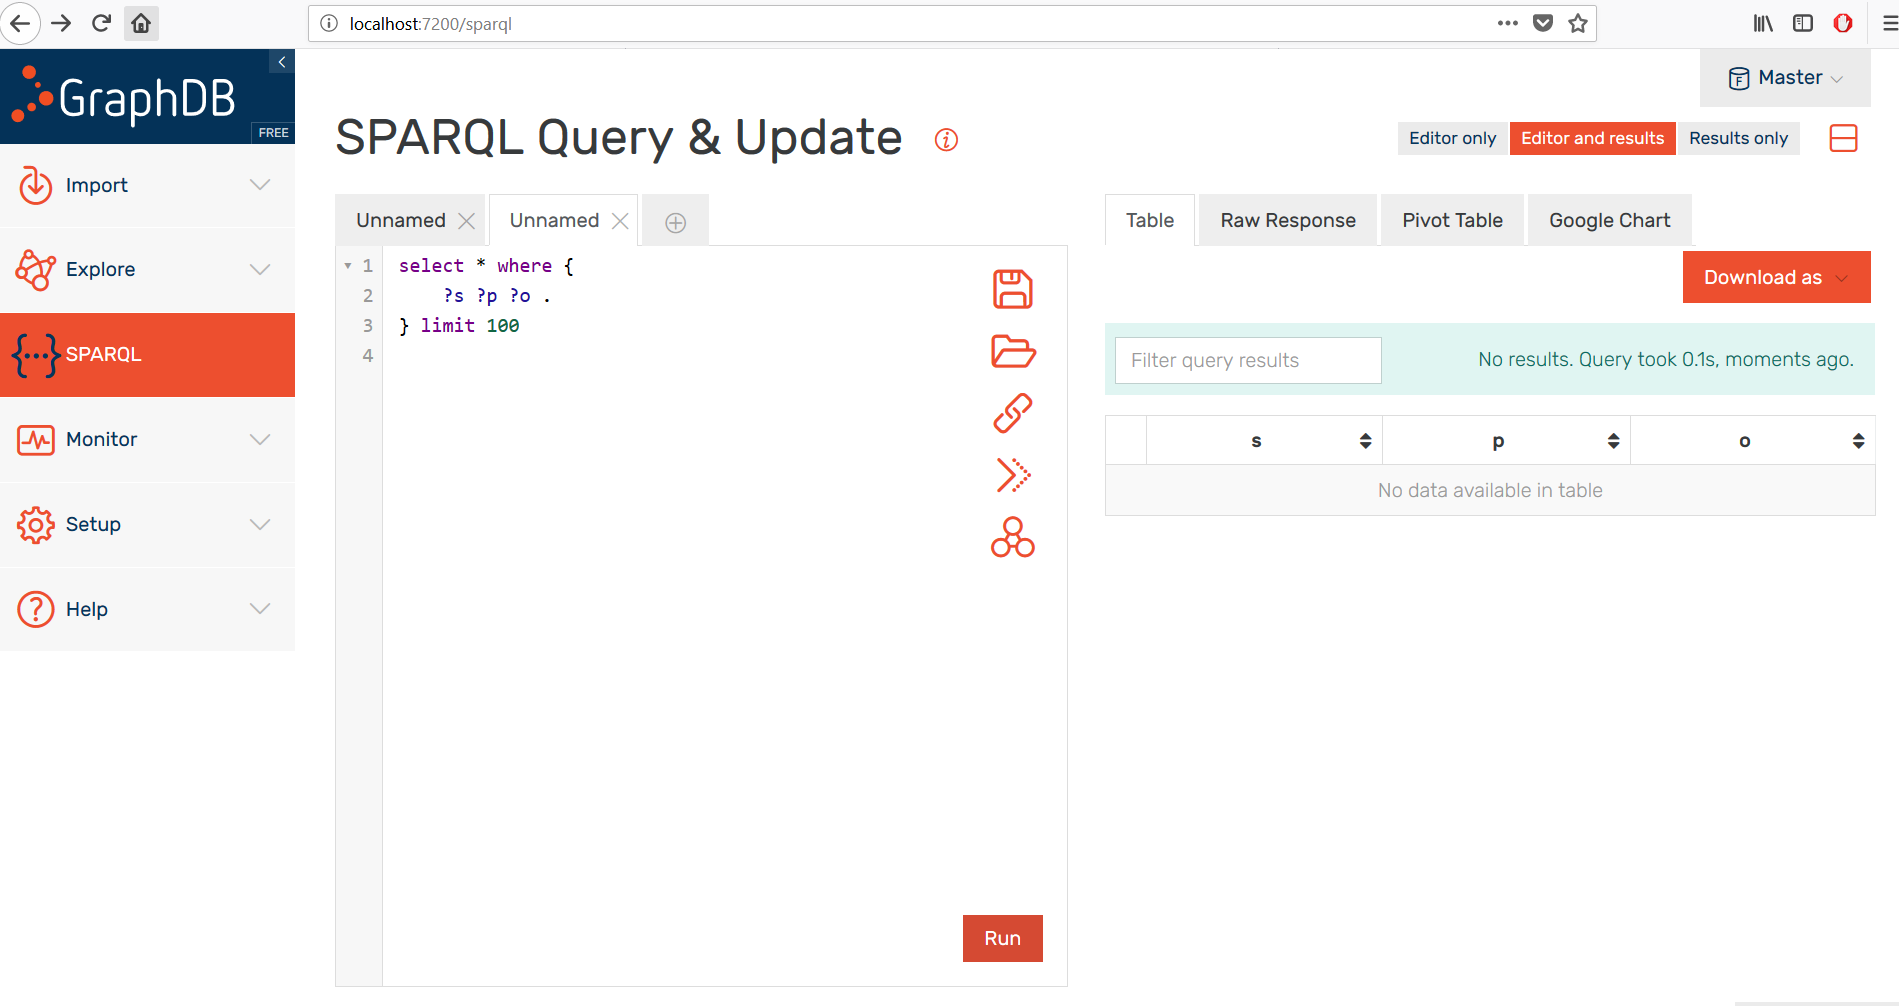

In [4]:
r = requests.get("http://localhost:7200/repositories/Master/size")
print("Number of statements in repository: ", r.text)

from IPython.display import Image
Image(filename='triplestore_before.png')

### Load RDF data into triplestore

In [5]:
url = 'http://localhost:7200/repositories/Master/statements'
headers = {'Content-Type':'text/turtle'}
r = requests.request(method='POST', url=url, data=payload, headers=headers)
print("HTTP response code: ", r.status_code)

HTTP response code:  204


Number of statements in repository:  6


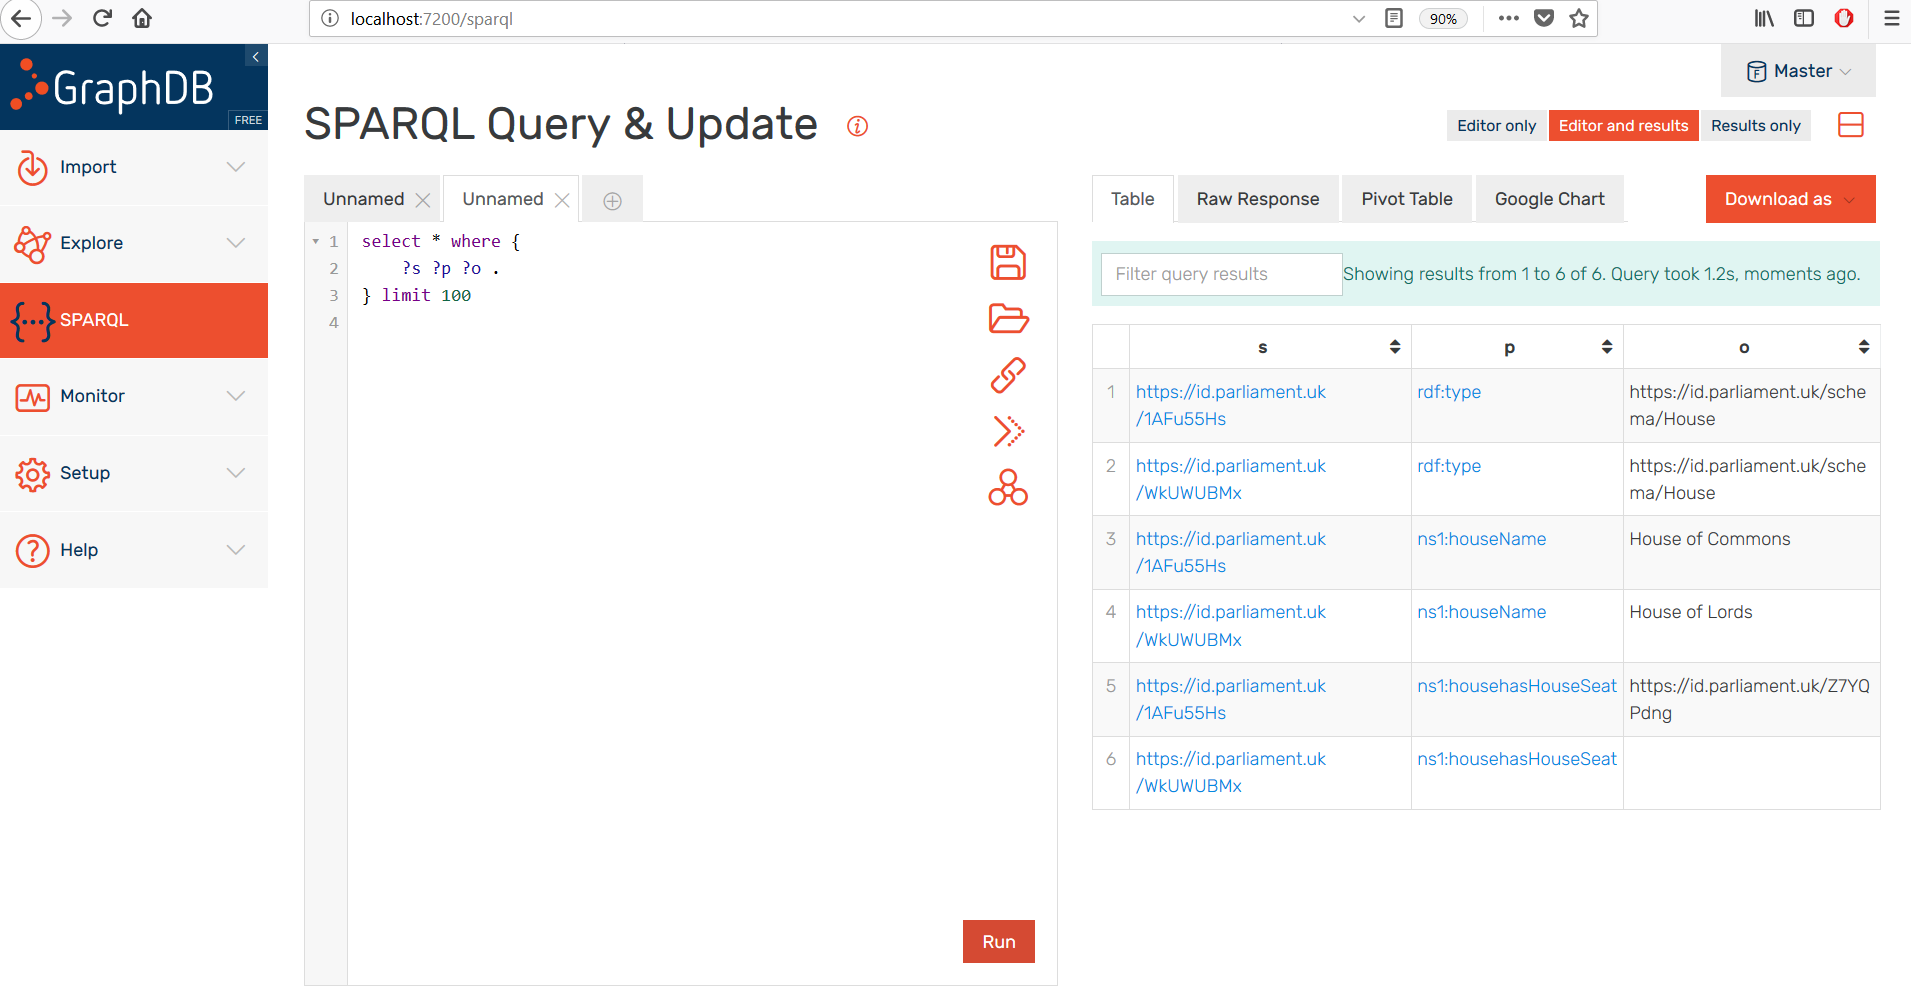

In [6]:
r = requests.get("http://localhost:7200/repositories/Master/size")
print("Number of statements in repository: ", r.text)

from IPython.display import Image
Image(filename='triplestore_after.png')

There was previous talk of adding RDF support for linked datasets into `pandas` which did not happen (see [thread](https://github.com/pandas-dev/pandas/issues/3402)). There have been attempts to develop such support in supplementary packages, funnily enough named [`pandasrdf`](https://github.com/westurner/pandasrdf) and [`rdfpandas`](https://github.com/cadmiumkitty/rdfpandas), both of which do not currently have active development communities around them. 

The above example uses the latter. There are indeed some issues here, the major ones being the package treats IRIs as literals, and it doesn't deal with nulls/ blanks correctly (see [RDF specs](https://www.w3.org/TR/rdf11-concepts/#section-IRIs) for more on IRIs). 

Suffice it to say there isn't currently a great ecosystem of support for RDF in python, definitely at least compared to what dotNetRDF offers in C#. There're better ways of orchestrating data into a triplestore than with a python pipeline. 

That said, the above demonstrates the basic feasibility of convert some relational data into RDF and loading it into a triplestore in python, notwithstanding issues when the pipeline scales. 

Perhaps more usefully, how about the other way round?

### Part 2: RDF &rightarrow; pandas dataframe 

This uses the `SPARQLWrapper` package from `RDFLib`. 

I use this package as it recently added support for custom HTTP headers ([commit](https://github.com/RDFLib/sparqlwrapper/commit/66fbbbc1a44609e0f0e89e8fb41fe88fc2cbedd2)).

The UK Parliament SPARQL endpoint, while read-only and rate-limited, is currently under development and requires a subscription key. This is passed in the HTTP POST request in a header.

In [7]:
from SPARQLWrapper import SPARQLWrapper2

wrapper = SPARQLWrapper2("https://api.parliament.uk/Live/sparql-endpoint/master?")
wrapper.customHttpHeaders = {'Content-Type': 'application/sparql-query', 'Ocp-Apim-Subscription-Key': 'INSERT_KEY'}

In [8]:
from SPARQLWrapper import XML, GET, POST, JSON, JSONLD, N3, TURTLE, RDF, SELECT, INSERT, RDFXML, CSV, TSV
from SPARQLWrapper import URLENCODED, POSTDIRECTLY

wrapper.setQuery("""
PREFIX : <https://id.parliament.uk/schema/>
SELECT ?displayAs ?houseName ?weblink
WHERE {
    ?person a :Person .
    OPTIONAL { ?person :personGivenName ?givenName } .
    OPTIONAL { ?person :personFamilyName ?familyName } .
    OPTIONAL { ?person <http://example.com/F31CBD81AD8343898B49DC65743F0BDF> ?displayAs } .
    OPTIONAL { ?person :personHasPersonWebLink ?weblink } .
    
    ?person :memberHasParliamentaryIncumbency ?incumbency .
    FILTER NOT EXISTS { ?incumbency a :PastParliamentaryIncumbency . }
    FILTER NOT EXISTS {
        ?incumbency :incumbencyHasIncumbencyInterruption ?interruption.
        FILTER NOT EXISTS {
          ?interruption :endDate ?end.
        }
    }
    ?incumbency :seatIncumbencyHasHouseSeat ?houseSeat .
    ?houseSeat :houseSeatHasHouse ?house .
    ?house :houseName ?houseName .
    FILTER regex(str(?weblink), "twitter", "i")
}
ORDER BY ?houseName
""")
wrapper.setMethod(POST)
wrapper.setRequestMethod(POSTDIRECTLY)
results = wrapper.query().convert()

In [9]:
df = pd.DataFrame(results.bindings)
df.head()

,displayAs,houseName,weblink
0,Value(literal:'Adam Afriyie'),Value(literal:'House of Commons'),Value(uri:'https://twitter.com/AdamAfriyie')
1,Value(literal:'Afzal Khan'),Value(literal:'House of Commons'),Value(uri:'https://twitter.com/Afzal4Gorton')
2,Value(literal:'Alan Brown'),Value(literal:'House of Commons'),Value(uri:'https://twitter.com/alanbrownsnp')
3,Value(literal:'Alan Mak'),Value(literal:'House of Commons'),Value(uri:'https://twitter.com/AlanMakMP')
4,Value(literal:'Albert Owen'),Value(literal:'House of Commons'),Value(uri:'https://twitter.com/AlbertOwenMP')


In [10]:
def extract(binding):
    return binding.value

df.applymap(extract).head()

,displayAs,houseName,weblink
0,Adam Afriyie,House of Commons,https://twitter.com/AdamAfriyie
1,Afzal Khan,House of Commons,https://twitter.com/Afzal4Gorton
2,Alan Brown,House of Commons,https://twitter.com/alanbrownsnp
3,Alan Mak,House of Commons,https://twitter.com/AlanMakMP
4,Albert Owen,House of Commons,https://twitter.com/AlbertOwenMP


Besides `SELECT`, `SPARQLWrapper` also supports `CONSTRUCT`, `ASK`, and `DESCRIBE` queries. ([docs](https://rdflib.github.io/sparqlwrapper/doc/latest/)).

Technically, in the above example, we still had to convert the JSON response into a pandas dataframe. A package called `gastrodon` (like the pokemon...) has even better pandas dataframe integration.

But it currently doesn't support custom HTTP headers when calling a remote SPARQL endpoint.

In [11]:
from gastrodon import RemoteEndpoint,QName,ttl,URIRef,inline

Here, my example uses the [MusicBrainz SPARQL endpoint](https://wiki.musicbrainz.org/LinkedBrainz). 

They are fairly random queries: the first returns the musical records with high number of tracks (>20), the second shows that apparently most artist names start with the letter `T`.

Depending on subject interest, there are [many other SPRARQL endpoints](https://www.w3.org/wiki/SparqlEndpoints) from a wide range of organizations and data publishers. They vary quite a bit: some are built in-house and some [out-sourced](https://medium.swirrl.com/), with different backends as well as levels of maintenance. Some vendors may not supoort all parts of the SPARQL 1.1 specification, some may have extensions for additional capability, but the basics should generally be supported. 

If we have a) an endpoint that supports [federated SPARQL queries](https://www.w3.org/TR/sparql11-federated-query/) and b) datasets with classes that are annotated with predicates like [`owl:sameAs`](https://www.w3.org/TR/owl-ref/#sameAs-def), we can start to expand the scope of our questions due to (relatively easy) data linkage between datasets.

In [12]:
prefixes=inline("""
    @prefix mo: <http://purl.org/ontology/mo/>.
    @prefix mbz: <http://purl.org/ontology/mbz#>.
    @prefix owl: <http://www.w3.org/2002/07/owl#>.
    @prefix xsd: <http://www.w3.org/2001/XMLSchema#>.
    @prefix bio: <http://purl.org/vocab/bio/0.1/>.
    @prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#>.
    @prefix tags: <http://www.holygoat.co.uk/owl/redwood/0.1/tags/>.
    @prefix geo: <http://www.geonames.org/ontology#>.
    @prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>.
    @prefix lingvoj: <http://www.lingvoj.org/ontology#>.
    @prefix rel: <http://purl.org/vocab/relationship/>.
    @prefix vocab: <http://dbtune.org/musicbrainz/resource/vocab/>.
    @prefix event: <http://purl.org/NET/c4dm/event.owl#>.
    @prefix map: <file:/home/moustaki/work/motools/musicbrainz/d2r-server-0.4/mbz_mapping_raw.n3#>.
    @prefix db: <http://dbtune.org/musicbrainz/resource/>.
    @prefix foaf: <http://xmlns.com/foaf/0.1/>.
    @prefix dc: <http://purl.org/dc/elements/1.1/>.
    """).graph

In [13]:
endpoint=RemoteEndpoint(
    "http://dbtune.org/musicbrainz/sparql",
    prefixes=prefixes,
    base_uri="http://dbtune.org/musicbrainz/resource/"
)

In [14]:
df=endpoint.select("""
SELECT ?artistName ?recordTitle ?tracks ?language ?coverArt 
WHERE {
    ?record a mo:Record;
        dc:title ?recordTitle;
        foaf:maker ?s;
        dc:language ?lang;
        vocab:albummeta_coverarturl ?coverArt;
        vocab:tracks ?tracks.
    ?lang lingvoj:iso2b ?language.
    ?s a mo:MusicArtist;
        foaf:name ?artistName.
    FILTER (?tracks>=20)
}
ORDER BY DESC(?tracks)
""")
df

,artistName,recordTitle,tracks,language,coverArt
0,池頼広,ソニックＸ オリジナルサウンドトラックス,40,jpn,http://ec1.images-amazon.com/images/P/B0001AEL...
1,Fell Venus,@,37,eng,
2,Various Artists,なるたる,30,jpn,http://ec1.images-amazon.com/images/P/B0000C9V...
3,田中公平,おたくのビデオ,30,jpn,http://ec1.images-amazon.com/images/P/B000UVES...
4,松谷卓,のだめカンタービレ,26,jpn,http://ec1.images-amazon.com/images/P/B000MZHT...
5,菅野よう子,エスカフローネ,26,jpn,http://images-jp.amazon.com/images/P/B00005072...
6,近藤浩治,☆スーパーマリオ☆ ヨッシーアイランド オリジナル・サウンド ヴァージョン,26,jpn,http://ec1.images-amazon.com/images/P/B00005FN...
7,RUX,우린 어디로 가는가,25,kor,
8,조영욱,싸이보그지만 괜찮아,25,kor,http://ec1.images-amazon.com/images/P/B000LYE8...
9,Various Artists,おもひでぽろぽろ,24,jpn,http://ec1.images-amazon.com/images/P/B00005GF...


We can see `gastrodon` has the nice feature of returning a usable `pandas` dataframe straight from the query.

It also integrates gracefully with displaying namespaces and turning the `GROUP BY` variable into the df index, as shown below. 

Compared to `SPARQLWrapper`, this saves data wrangling time.

In [15]:
df=endpoint.select("""

SELECT ?firstLetter (COUNT (?s) as ?n_artists) 
WHERE {
    ?s a mo:MusicArtist;
        foaf:name ?artistName.
    BIND(UCASE(SUBSTR(?artistName, 1, 1)) AS ?firstLetter)
} 
GROUP BY ?firstLetter ORDER BY DESC(?n_artists)
""")
df.head()

,n_artists
firstLetter,
T,93
S,87
M,82
J,70
D,63


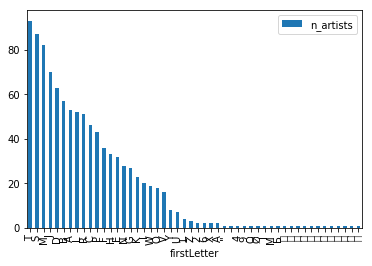

In [16]:
%matplotlib inline
df.plot.bar()

The author of `gastrodon` has written a bunch of interesting notebooks for both local and remote endpoints [here](https://github.com/paulhoule/gastrodon/tree/master/notebooks).

For more, there is also the [SPARQL Jupyter kernel](https://github.com/paulovn/sparql-kernel) (see [example](https://github.com/cadmiumkitty/rdf-jupyter/blob/master/work/sparql-kernel-example.ipynb) from Semantic Web London meetup). However, as things stand now, the python packages are more user-friendly than the SPARQL kernel as they allow you to put both your SPARQL query and python code in the same notebook.

### So what's the verdict?

Based on the above, it seems the answer is yes, we can work with RDF data in python. It's imperfect but there are tools that are developing.

Why might working with RDF data in python be desirable anyway? 
- Brings datasets closer to the data science community. Many actively-developed open-source data wrangling, network analysis and ML libraries are in python. Greater interoperability means it's easier for users to generate potential new insights.
- Better re-use and higher visibility. Things like Jupyter notebooks allow for compelling story-telling about potentially large quantities of data, in a way that's easily shared and reproduced. 
- There may be data pipelines already built in python that we wish to integrate with. 

If the goal is wider adoption of W3C's semantic web standards and recommendations (RDF, OWL, SPARQL, SKOS etc), then better integration with popular scripting and data analysis languages like python definitely wouldn't hurt.

It's also worth adding that while python remains one of the most popular tools for data science, some triplestores are adding native ML capabilities (e.g. [Stardog Predictive Analytics API](https://www.stardog.com/docs/#_predictive_analytics?) allows for easier model building, graph-native NLP capabilities), which is quite exciting. There may be concerns of reproducability when RDF data changes. This may be addressed by [reification][reify] (statements about statements) and [provenance](https://www.w3.org/TR/prov-o/) (information about the people and activities that produced the data), which are used in RDF for versioning data/ boosting reliability and trustworthiness.

[reify]:https://en.wikipedia.org/wiki/Reification_(computer_science)#RDF_and_OWL